## DES collection import

Author: Melissa D

Last run: <TODO>

https://github.com/astronomy-commons/data.lsdb.io/issues/99

In [1]:
# %pip install -U hats-import

In [2]:
import hats
import hats_import
import numpy as np
from dask.distributed import Client
from hats_import import CollectionArguments, pipeline_with_client, pipeline, VerificationArguments
from pathlib import Path
from hats_import.catalog.file_readers import CsvReader
from astropy.io import ascii
import lsdb

hats_import.__version__

/astro/users/mmd11/.conda/envs/importenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'0.6.2'

In [3]:
## input paths:
raw_dir = Path("/data3/epyc/data3/hats/raw/des/des_dr2/")
file_list = list(raw_dir.glob("DES*"))
print("found", len(file_list), "files for import")

# ## Index division hints
# global_min = 4295806720
# global_max = 6917528997577384320
# num_row_groups = 3933

# increment = int((global_max - global_min) / num_row_groups)

# divisions = np.append(np.arange(start=global_min, stop=global_max, step=increment), global_max)
# divisions = divisions.tolist()

# ## Create a schema file, using the contents from the VOTable.

# empty_astropy_table = ascii.read(file_list[0], format="ecsv", data_end=1)
# empty_astropy_table.write("gaia_schema.parquet", overwrite=True)

found 9736 files for import


In [7]:
args = (
    CollectionArguments(
        completion_email_address="delucchi@andrew.cmu.edu",
        output_artifact_name="des_dr2",
        output_path="/data3/epyc/data3/hats/catalogs/v06",
        progress_bar=True,
        simple_progress_bar=True,
    )
    .catalog(
        output_artifact_name="des_dr2",
        input_file_list=file_list,
        file_reader="fits",
        ra_column="RA",
        dec_column="DEC",
        sort_columns="COADD_OBJECT_ID",
        highest_healpix_order=7,
        skymap_alt_orders=[2, 4, 6],
        pixel_threshold=1_000_000,
        row_group_kwargs={"num_rows": 200_000},
    )
    .add_margin(margin_threshold=10.0, is_default=True)
#     .add_margin(margin_threshold=300.0, output_artifact_name="gaia_300arcs")
#     .add_index(
#         indexing_column="source_id",
#         output_artifact_name="gaia_source_id_index",
#         include_healpix_29=False,
#         include_order_pixel=True,
#         compute_partition_size=2_000_000_000,
#         division_hints=divisions,
#         drop_duplicates=False,
#     )
)

In [8]:
with Client(
    local_directory="/data3/epyc/data3/hats/tmp/",
    n_workers=20,
    threads_per_worker=1,
) as client:
    pipeline_with_client(args, client)

Planning  : 100%|██████████| 4/4 [00:00<00:00,  8.22it/s]

tmp_path (/data3/epyc/data3/hats/catalogs/v06/des_dr2/intermediate/des_dr2/intermediate) contains intermediate files; resuming prior progress.



Finishing : 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


In [9]:
catalog = lsdb.open_catalog("/data3/epyc/data3/hats/catalogs/v06/des_dr2")
len(catalog.margin)

10147366

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - des_dr2'}>)

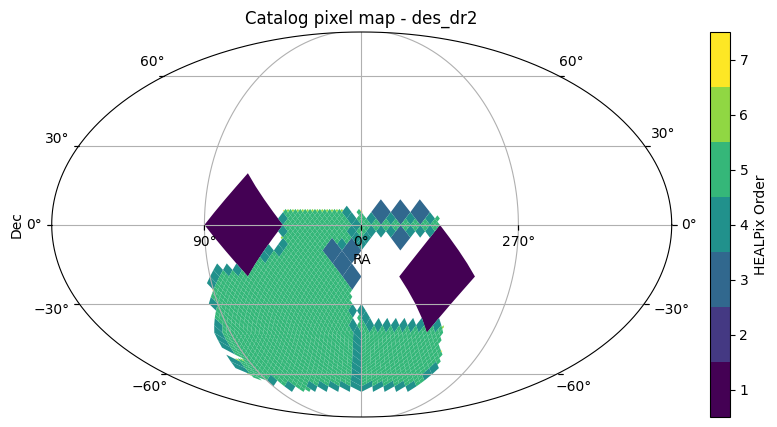

In [10]:
catalog.plot_pixels()

In [13]:
args = VerificationArguments(
    input_catalog_path="/data3/epyc/data3/hats/catalogs/v06/des_dr2/des_dr2",
    output_path="./verification/des_dr2",
)
pipeline(args)

Loading dataset and schema.

Starting: Test hats.io.validation.is_valid_catalog.
Validating catalog at path /data3/epyc/data3/hats/catalogs/v06/des_dr2/des_dr2 ... 
Found 1523 partitions.
Approximate coverage is 19.09 % of the sky.
Result: PASSED

Starting: Test that files in _metadata match the data files on disk.
Result: PASSED

Starting: Test that number of rows are equal.
	file footers vs catalog properties
	file footers vs _metadata
Result: PASSED

Starting: Test that schemas are equal, excluding metadata.
	_common_metadata vs truth
	_metadata vs truth
	file footers vs truth
Result: PASSED

Verifier results written to verification/des_dr2/verifier_results.csv
Elapsed time (seconds): 53.61


We need to expand the verification pipeline to allow passing a catalog collection, and verify that all of the necessary elements of the catalog collection are present. 

This is being tracked in issue: https://github.com/astronomy-commons/hats-import/issues/566

Here, we instead spot-check that the collection looks "about right".

In [14]:
!ls /data3/epyc/data3/hats/catalogs/v06/des_dr2/

collection.properties  des_dr2	des_dr2_10arcs


In [15]:
!cat /data3/epyc/data3/hats/catalogs/v06/des_dr2/collection.properties

#HATS Collection
obs_collection=des_dr2
hats_primary_table_url=des_dr2
all_margins=des_dr2_10arcs
default_margin=des_dr2_10arcs
hats_builder=hats-import v0.6.2, hats v0.6.2
hats_creation_date=2025-08-11T22:40UTC
hats_estsize=698563602
hats_release_date=2024-09-18
hats_version=v0.1
